# Time-Travel
- Langgraph supports debugging by viewing, re-playing and even forking from past states

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

## Basic Agent Creation

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

c:\Users\manan\anaconda3\envs\langgraph_env\Lib\site-packages\pydantic\_internal\_generate_schema.py:913: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `BaseMessage` to V2.
  warn(


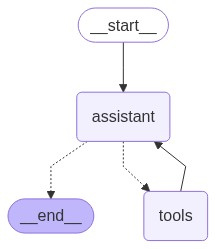

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before

In [47]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gOCNUTMu8OFJMM4iM6gMWjKZ)
 Call ID: call_gOCNUTMu8OFJMM4iM6gMWjKZ
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

In [48]:
graph.get_state(thread)
# It gives us the snapshot of "Current" state!

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gOCNUTMu8OFJMM4iM6gMWjKZ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eed4adf9-da2a-4af0-bfd3-7be6f8f377f6-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_gOCNUTMu8OFJMM4iM6gMWjKZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148

In [49]:
all_states = [s for s in graph.get_state_history(thread)]

In [50]:
len(all_states)

5

In [28]:
# all_state[0] -> Current state... Then we can go back in time
# all_states[-1] -> Human Input, will be the input of the node: Start
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='70bafcc0-05d6-4b3d-9d66-55d523a506d5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04f8bc-75cf-66d5-8000-ebce6544e56b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-22T17:10:21.229230+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04f8bc-75cf-66d4-bfff-3bee48d124de'}}, tasks=(PregelTask(id='90553a18-0a21-c541-4285-b10ea5277adb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZhtMf6z48tcvwF1to3wAA9lO', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tok

In [23]:
all_states[-5] == graph.get_state(thread) and all_states[0] == graph.get_state(thread)

True

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [35]:
# Let's replay from the node where we got the human input i.e next is assistant
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='70bafcc0-05d6-4b3d-9d66-55d523a506d5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04f8bc-75cf-66d5-8000-ebce6544e56b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-22T17:10:21.229230+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04f8bc-75cf-66d4-bfff-3bee48d124de'}}, tasks=(PregelTask(id='90553a18-0a21-c541-4285-b10ea5277adb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZhtMf6z48tcvwF1to3wAA9lO', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tok

In [39]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', id='70bafcc0-05d6-4b3d-9d66-55d523a506d5')]}

In [36]:
to_replay.next

('assistant',)

In [40]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04f8bc-75cf-66d5-8000-ebce6544e56b'}}

In [43]:
# Let's replay from here
for event in graph.stream(None, to_replay.config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_FCNEyQ7lYa59NzQbYOJsnPvm)
 Call ID: call_FCNEyQ7lYa59NzQbYOJsnPvm
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [51]:
all_states_2 = [s for s in graph.get_state_history(thread)]
len(all_states_2)

5

In [52]:
all_states_2

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gOCNUTMu8OFJMM4iM6gMWjKZ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eed4adf9-da2a-4af0-bfd3-7be6f8f377f6-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_gOCNUTMu8OFJMM4iM6gMWjKZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 14

## Forking
What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [64]:
to_fork = all_states_2[-2]
to_fork.values['messages']

[HumanMessage(content='Multiply 2 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea')]

In [65]:
to_fork.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04f92b-d650-6489-8000-cd6dd93dfa73'}}

In [67]:
# We want to update the state, keeping in mind the reducer
fork_config = graph.update_state(
    to_fork.config,
    {'messages':[HumanMessage(content="Multiple 5 and 3", id = to_fork.values['messages'][0].id)]}
)

In [68]:
fork_config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04f941-85f7-6399-8001-65809f42923d'}}

In [71]:
# See, the Input has been updated
all_states_2 = [s for s in graph.get_state_history(thread)]
all_states_2[0]

StateSnapshot(values={'messages': [HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04f941-85f7-6399-8001-65809f42923d'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea')]}}, 'step': 1, 'parents': {}, 'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04f92b-d650-6489-8000-cd6dd93dfa73'}, created_at='2025-06-22T18:09:53.114818+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04f92b-d650-6489-8000-cd6dd93dfa73'}}, tasks=(PregelTask(id='00a375a5-78bf-93e1-99cc-0b842d3d5407', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [73]:
all_states_2

[StateSnapshot(values={'messages': [HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04f941-85f7-6399-8001-65809f42923d'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea')]}}, 'step': 1, 'parents': {}, 'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04f92b-d650-6489-8000-cd6dd93dfa73'}, created_at='2025-06-22T18:09:53.114818+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04f92b-d650-6489-8000-cd6dd93dfa73'}}, tasks=(PregelTask(id='00a375a5-78bf-93e1-99cc-0b842d3d5407', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='f07327c0-

In [74]:
# Let's Stream from the new checkpoint
for event in graph.stream(None, fork_config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiple 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tNlyhurVtXFzzGscH7R6hx0D)
 Call ID: call_tNlyhurVtXFzzGscH7R6hx0D
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [76]:
all_states_2 = [s for s in graph.get_state_history(thread)]
all_states_2

[StateSnapshot(values={'messages': [HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tNlyhurVtXFzzGscH7R6hx0D', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4413f11e-89f9-40eb-906f-00341c622400-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_tNlyhurVtXFzzGscH7R6hx0D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 14

### Glimpse into the `state['messages]` key

In [85]:
all_states_2[-7].values['messages']

[HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tNlyhurVtXFzzGscH7R6hx0D', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4413f11e-89f9-40eb-906f-00341c622400-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_tNlyhurVtXFzzGscH7R6hx0D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148})]

In [86]:
all_states_2[-8].values['messages']

[HumanMessage(content='Multiple 5 and 3', id='f07327c0-e61c-4787-81a9-30d1a7b32fea'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tNlyhurVtXFzzGscH7R6hx0D', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4413f11e-89f9-40eb-906f-00341c622400-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_tNlyhurVtXFzzGscH7R6hx0D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148}),
 ToolMessage(content='15', na

## Time-Travel with LangGraph API

In [87]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [96]:
assistants = await client.assistants.search()
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-06-22T18:22:00.394427+00:00',
  'updated_at': '2025-06-22T18:22:00.394427+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-06-22T18:22:00.387112+00:00',
  'updated_at': '2025-06-22T18:22:00.387112+00:00',
  'version': 1,
  'description': None}]

### Replaying

In [106]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_K22riKJr4uYgrFpCS1smwexP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-4f794b9a-773a-4166-aeb4-a4d2539e7d27-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_K22riKJr4uYgrFpCS1smwexP', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to

In [107]:
thread['thread_id']

'6d3d2ee0-c788-4f7f-ae81-f303d8f36043'

In [108]:
states = await client.threads.get_history(thread_id=thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'bb1aba43-5016-4f8b-8152-0473e9dafe77',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '34e089be-c9d2-65df-26cd-12e3e165366b',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_K22riKJr4uYgrFpCS1smwexP',
         'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
         'type': 'function'}],
       'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 17,
        'prompt_tokens': 134,
        'total_tokens': 151,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'au

In [109]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f04f974-ec83-63fa-97ab-f52fb34bc112', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'bb1aba43-5016-4f8b-8152-0473e9dafe77', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'bb1aba43-5016-4f8b-8152-0473e9dafe77', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_XIJkqoKghWfrpvkRgFAyUKZE', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_toke

In [110]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_n4oneCnHs59jodpKqOMARKwy', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-83e6a397-382a-4501-b2be-b93920816102-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_n4oneCnHs59jodpKqOMARKwy', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to

### Forking

In [111]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_K4IecPdpVzuTQMLBea5tLVte', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-8db805da-ae66-4db1-9a95-2366372d0d47-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_K4IecPdpVzuTQMLBea5tLVte', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to

In [112]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'additional_kwargs': {},
    'response_metadata': {},
    'example': False},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '48e70ed2-5a1f-4386-a4b9-1cbcc74976b8',
   'example': False}]}

In [113]:
to_fork['values']['messages'][0]['id']

'48e70ed2-5a1f-4386-a4b9-1cbcc74976b8'

In [114]:
to_fork['next']

['assistant']

In [115]:
to_fork['checkpoint_id']

'1f04f979-a9e7-68fa-8000-4bb391340250'

In [117]:
# Edit the state
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [119]:
forked_config

{'checkpoint': {'thread_id': '64befdd3-114d-4bbc-8ccc-2d9f92a71742',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04f97b-4cfe-6266-8001-ce3268d901a7'},
 'configurable': {'thread_id': '64befdd3-114d-4bbc-8ccc-2d9f92a71742',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04f97b-4cfe-6266-8001-ce3268d901a7'},
 'checkpoint_id': '1f04f97b-4cfe-6266-8001-ce3268d901a7'}

In [120]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '48e70ed2-5a1f-4386-a4b9-1cbcc74976b8',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '00bfa3e0-bf61-2954-489a-90e6a62da18f',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'agent',
  'thread_id': '64befdd3-114d-4bbc-8ccc-2d9f92a71742',
  'checkpoint_id': '1f04f979-a9e7-68fa-8000-4bb391340250',
  'checkpoint_ns': '',
  'user-agent': 'langgraph-sdk-py/0.1.70',
  'x-request-id': 'f227fe04-f456-41e0-acdc-33f21928af28',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': 'f227fe04-f456-41e0-acdc-33f21928af28',
  'assi

In [121]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_rgo4i9z4TKCOzDMCnjjAbkZe', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-5b9a4e54-fb7e-4386-965c-d0db07318017-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_rgo4i9z4TKCOzDMCnjjAbkZe', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to